In [1]:
# 建模与训练
def getModel():
    input_layer = Input(shape=(x.shape[1],))
    encoded = Dense(8, activation='relu', activity_regularizer=regularizers.l2(10e-5))(input_layer)  # l2正则化约束
    decoded = Dense(x.shape[1], activation='relu')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

In [2]:
# calculate_losses是一个辅助函数，计算每个数据样本的重建损失
def calculate_losses(x, preds):
    losses = np.zeros(len(x))
    for i in range(len(x)):
        losses[i] = ((preds[i] - x[i]) ** 2).mean(axis=None)
    return losses

In [3]:
import time
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve

Using TensorFlow backend.


In [4]:
# 手动添加特征，训练集42，测试集41

feather = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 
           'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations', 
           'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 
           'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
           'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']

In [5]:
# TRAIN_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\UNSW-NB 15\\UNSW_NB15_training-set.csv'
TRAIN_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\kddcup\\train_10_percent_kddcup.csv'
TEST_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\kddcup\\test_10_percent_kddcup.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DATA_PATH, header = None, names = feather)
test_df = pd.read_csv(TEST_DATA_PATH, header = None, names = feather)

C:\Users\Qin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


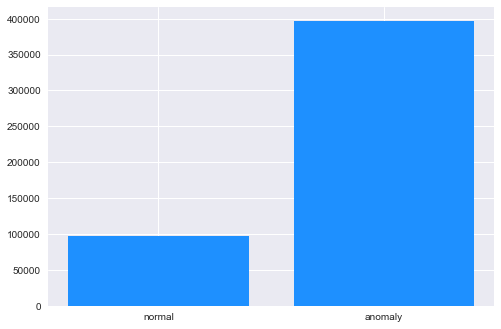

In [7]:
# 读取数据
# 查看样本比例
normal = np.sum(train_df['label'] == 0)
anomaly = np.sum(train_df['label'] != 0)
plt.bar(['normal', 'anomaly'], [normal, anomaly], color='dodgerblue')
plt.show()

In [8]:
train_df = train_df[train_df['label'] == 0]

In [9]:
testLabel = test_df['label']

In [10]:
test_normal = test_df[test_df['label'] == 0]
test_anomaly = test_df[test_df['label'] != 0]

In [11]:
# 删除所有分类列
train_df.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'], axis = 1, inplace = True)
# 删除无标准偏差的列
# train_df.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'lsu_attempted', 'lnum_file_creations', 'lnum_outbound_cmds'], axis = 1, inplace = True)

# 删除所有分类列
test_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'], axis = 1, inplace = True)
# 删除无标准偏差的列
# test_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'lsu_attempted', 'lnum_file_creations', 'lnum_outbound_cmds'], axis = 1, inplace = True)

# 删除所有分类列
test_anomaly.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'], axis = 1, inplace = True)
# 删除无标准偏差的列
# test_anomaly.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'lsu_attempted', 'lnum_file_creations', 'lnum_outbound_cmds'], axis = 1, inplace = True)

C:\Users\Qin\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# 设置Autoencoder的参数
# 隐藏层节点数分别为16，8，8，16
# epoch为50，batch size为32
input_dim = train_df.shape[1]
encoding_dim = 16
num_epoch = 50
batch_size = 64

input_layer = Input(shape=(input_dim, ))
# 五层结构:X -> 16 -> 8 -> 16 -> X'
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])

In [13]:
# 模型保存为SofaSofa_model.h5，并开始训练模型
checkpointer = ModelCheckpoint(filepath="kddcup.h5",
                               verbose=0,
                               save_best_only=True)
start = time.clock()
history = autoencoder.fit(train_df, train_df,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_normal, test_normal),
                          verbose=1, 
                          callbacks=[checkpointer]).history
end = time.clock()
print('Time : ', (end - start))

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


Train on 97278 samples, validate on 60593 samples
Epoch 1/50
97278/97278 [==============================] - 3s 30us/step - loss: 76418711.0641 - mae: 150.2713 - val_loss: 73530977.3120 - val_mae: 139.3516
Epoch 2/50
97278/97278 [==============================] - 2s 24us/step - loss: 76416375.8878 - mae: 149.5554 - val_loss: 73528870.9566 - val_mae: 138.6229
Epoch 3/50
97278/97278 [==============================] - 2s 23us/step - loss: 76414255.1876 - mae: 148.9307 - val_loss: 73526874.4900 - val_mae: 137.9509
Epoch 4/50
97278/97278 [==============================] - 2s 24us/step - loss: 76412169.4962 - mae: 148.3560 - val_loss: 73524849.0010 - val_mae: 137.2984
Epoch 5/50
97278/97278 [==============================] - 2s 25us/step - loss: 76410088.1444 - mae: 147.8117 - val_loss: 73522861.6182 - val_mae: 136.6707
Epoch 6/50
97278/97278 [==============================] - 2s 25us/step - loss: 76408032.3300 - mae: 147.3031 - val_loss: 73520841.2226 - val_mae: 136.0718loss: 64441782.8716 -

97278/97278 [==============================] - 2s 25us/step - loss: 76331523.5414 - mae: 136.5799 - val_loss: 73448228.4572 - val_mae: 125.3633
Epoch 50/50
97278/97278 [==============================] - 2s 24us/step - loss: 76329915.3776 - mae: 136.4079 - val_loss: 73446722.6021 - val_mae: 125.2371
Time :  118.3227609


C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


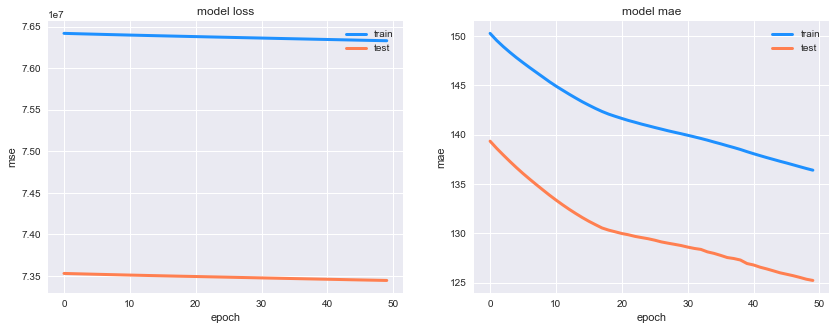

In [14]:
# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(122)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.plot(history['val_mae'], c='coral', lw=3)
plt.title('model mae')
plt.ylabel('mae'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [15]:
# 读取模型
autoencoder = load_model('kddcup.h5')

# 利用训练好的autoencoder重建测试集
start = time.clock()
pred_normal = autoencoder.predict(test_normal)
pred_anomaly = autoencoder.predict(test_anomaly)
end = time.clock()
print('Time : ', (end - start))

# 计算还原误差MSE和MAE
mse_normal = np.mean(np.power(test_normal - pred_normal, 2), axis=1)
mse_anomaly = np.mean(np.power(test_anomaly - pred_anomaly, 2), axis=1)
mae_normal = np.mean(np.abs(test_normal - pred_normal), axis=1)
mae_anomaly = np.mean(np.abs(test_anomaly - pred_anomaly), axis=1)
mse_df = pd.DataFrame()
mse_df['Label'] = [0] * len(mse_normal) + [1] * len(mse_anomaly)
mse_df['MSE'] = np.hstack([mse_normal, mse_anomaly])
mse_df['MAE'] = np.hstack([mae_normal, mae_anomaly])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Time :  2.3334383000000116


In [17]:
pred = pd.Series([0 if i == 0 else 1 for i in mse_df['Label']])

In [18]:
labels = pd.Series([0 if i == 0 else 1 for i in testLabel])

In [19]:
labels

0         0
1         0
2         0
3         1
4         1
         ..
311024    0
311025    0
311026    0
311027    0
311028    0
Length: 311029, dtype: int64

In [23]:
prec, recall, fscore, _ = precision_recall_fscore_support(labels, pred, average="binary")
auc = roc_auc_score(labels, pred)
print(f" Precision = {prec:.5f}")
print(f" Recall    = {recall:.5f}")
print(f" F1-Score  = {fscore:.5f}")
print(f" AUC  = {auc:.5f}")

 Precision = 0.80575
 Recall    = 0.80575
 F1-Score  = 0.80575
 AUC  = 0.50146


In [62]:
confusion_matrix(labels, pred)

array([[ 11947,  48646],
       [ 48646, 201790]], dtype=int64)

In [65]:
(11947 + 201790) / len(pred)

0.6871931556221446

In [20]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [21]:
from sklearn.metrics import confusion_matrix

In [ ]:
# 分别画出测试集中正样本和负样本的还原误差MAE和MSE
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['normal', 'Anomaly']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Label'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE'); plt.xlabel('Index')
plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Label'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12); plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE'); plt.xlabel('Index')
plt.show()

In [ ]:
# 画出Precision-Recall曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    precision, recall, _ = precision_recall_curve(mse_df['Label'], mse_df[metric])
    recallSum = 0
    precisionSum = 0
    for i in precision :
        precisionSum += i
    for i in recall :
        recallSum += i
        
    precisionSum = precisionSum / len(precision)
    recallSum = recallSum / len(recall)
    print('precision = ', (metric, precisionSum))
    print('recall = ', (metric, recallSum))
    print('f1-score = ', (metric, (2 * precisionSum * recallSum / (precisionSum + recallSum))))
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall curve based on %s\nAUC = %0.2f'%(metric, pr_auc))
    plt.plot(recall[:-2], precision[:-2], c='coral', lw=4)
    plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()

In [ ]:
# 画出ROC曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    fpr, tpr, _ = roc_curve(mse_df['Label'], mse_df[metric])
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic based on %s\nAUC = %0.3f'%(metric, roc_auc))
    plt.plot(fpr, tpr, c='coral', lw=4)
    plt.plot([0,1],[0,1], c='dodgerblue', ls='--')
    plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

In [ ]:
# 画出MSE、MAE散点图
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['normal', 'Anomaly']

plt.figure(figsize=(10, 5))
for flag in [1, 0]:
    temp = mse_df[mse_df['Label'] == flag]
    plt.scatter(temp['MAE'], 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0])
plt.ylabel('Reconstruction RMSE'); plt.xlabel('Reconstruction MAE')
plt.show()